[View in Colaboratory](https://colab.research.google.com/github/nholmber/cp2k-analysis-tools/blob/master/examples/potential_colab.ipynb)

# Tool for manipulating potentials defined on a grid

The `potential.py` script is a tool to manipulate potentials defined on one- or two-dimensional rectangular axes. An example of a one-dimensional axis is the reaction coordinate along a nudged-elastic band simulation. The script takes as input a table of axis indices and (absolute) energies.

The script supports the following operations:
* Convert absolute energies to relative energies, optionally apply a unit conversion in the process
* Interpolate/Extrapolate potential with user-definable spline order and grid
* Locate minima, maxima and saddle points of potential

This notebook demonstrates the useage of `potential.py` with a simple example where an atom is translated between two molecules along a one-dimensional axis. The input potential was obtained from CP2K simulations of the system by extracting (`grep "ENERGY|" CP2K-output.out`) the system's energy and collecting the values to a text file. A two-dimensional example is also considered where two atoms are translated along two independent coordinates. 


##Setup Google Colab environment 

In [1]:
!git clone https://github.com/nholmber/cp2k-analysis-tools

Cloning into 'cp2k-analysis-tools'...
remote: Counting objects: 47, done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 47 (delta 14), reused 36 (delta 7), pack-reused 0
Unpacking objects: 100% (47/47), done.


In [2]:
%cd /content/cp2k-analysis-tools/examples/

/content/cp2k-analysis-tools/examples


##Setup notebook environment 

In [0]:
# Setup Python environment
import numpy as np

# Configure matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Add files to path
import sys
sys.path.append('../src/')
from potential import GridPotential

# Unit conversions
try:
    from ase.units import Hartree
except ModuleNotFoundError:
    # ASE is not installed -> use hardcoded value
    Hartree = 27.211386024367243

# Notebook magic
%load_ext autoreload
%autoreload 2

## 1-dimensional example



**Let's create a helper function which we will use later on to plot the 1D/2D potential**

In [0]:
# Define helper function plotting potential
def plot_potential(x, data, y=None, levels=None, fig=None, ax=None):
    if levels is None: levels = np.linspace(np.amin(data), np.amax(data), 5)
    
    if fig is None:
        fig = plt.figure(figsize=(10,8))
        ax = fig.add_subplot(1, 1, 1)
    else:
        if ax is None: ax = fig.gca()

    if y is None or x is None:
        # 1D Plot
        cp = ax.plot(x, data)

    else:
        # 2D Plot
        cp = ax.contourf(x, y, data, levels, cmap=plt.cm.RdBu_r)
        for c in cp.collections:
            c.set_edgecolor("face")
        ticks=np.linspace(np.amin(levels), np.amax(levels), 11)
        minorticks = np.setxor1d(levels, ticks)
        minorticks /= 3
        cb = plt.colorbar(cp, ticks=ticks)
        cb.solids.set_edgecolor("face")
        cb.ax.yaxis.set_ticks(minorticks, minor=True)
        cb.set_label('Energy (eV)', labelpad=10)

    return fig, ax, cp

**Read 1D-potential and process it  **

In [0]:
# Read 1D data
fname = 'data/data-1d.txt'
pot = GridPotential(fname, dimension=1)

# Convert data from absolute to relative scale and apply unit conversion (Hartree -> eV)
#minval = pot.global_minimum
pot.absolute_to_relative(unit=Hartree)

# Interpolate potential using default settings
interpolate = True
pot.interpolate()
x, _, data = pot.interpolated_potential

**Plot potential**

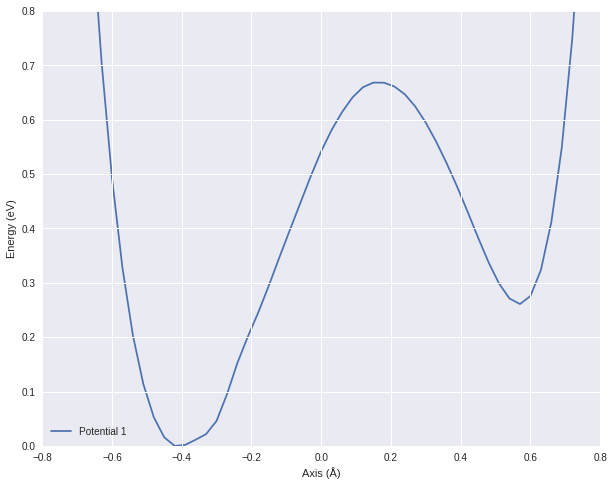

In [18]:
# Create plot
fig, ax, cp = plot_potential(x, data.T)

# Adjust plot appearance
from matplotlib.ticker import AutoMinorLocator
ax.set_axisbelow(False)

ax.set_ylim([-.0,.8])
ax.set_ylabel("Energy (eV)")

ax.set_xlim([-0.8,.8])
ax.set_xlabel("Axis (Å)")
ax.set_xticks(np.arange(-0.8, 1.0, 0.2))

minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)

plt.setp(cp, label="Potential 1")
ax.legend()
plt.show()

**Add a second data set to the figure**

In [0]:
# Lets add a second data set to the figure
fname = 'data/data-1d-2.txt'
pot = GridPotential(fname, dimension=1)
pot.absolute_to_relative(unit=Hartree)
pot.interpolate()
x, _, data = pot.interpolated_potential

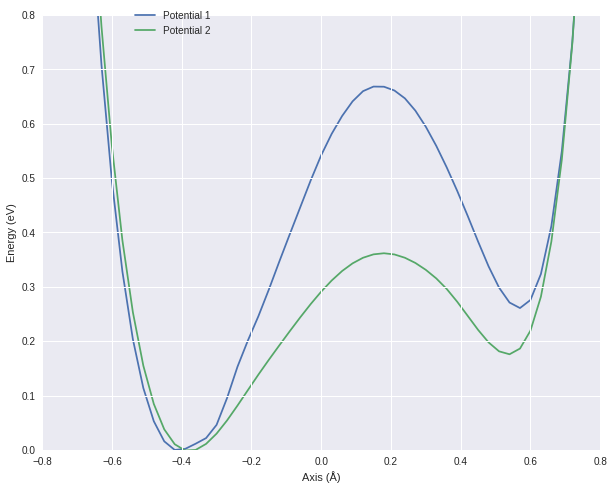

In [20]:
# Add new data set to existing plot
fig, ax, cp = plot_potential(x, data.T, fig=fig)
plt.setp(cp, label="Potential 2")
ax.legend(loc='upper left',  bbox_to_anchor=(0.15, 1.03))

# Must call the figure object to display plot (not plt.show() or fig.show())
fig

# 2-dimensional example

In [21]:
# Let's plot a 2-dimensional example
fname = 'data/data-2d.txt'
pot = GridPotential(fname, dimension=2)
pot.absolute_to_relative(unit=Hartree)
pot.interpolate()
x, y, data = pot.interpolated_potential

# Shift potential so that global minimum of interpolated potential is exactly 0 
if np.min(data) != 0.:
    data -= np.min(data)

# Find minima/maxima/saddle points
minima, maxima, saddles = pot.find_extrema(use_interpolated=True)

for i, j in minima:
    print('Found energy minimum at {:.2f}, {:.2f} with energy {:.2f} eV'.format(y[j], x[i], data[j][i]))
    
for i, j in maxima:
    # No maxima found
    print('Found energy maximum at {:.2f}, {:.2f} with energy {:.2f} eV'.format(y[j], x[i], data[j][i]))

for i, j in saddles:
    print('Found saddle point at {:.2f}, {:.2f} with energy {:.2f} eV'.format(y[j], x[i], data[j][i]))

Found energy minimum at -0.06, 0.69 with energy 0.00 eV
Found energy minimum at -0.21, -0.51 with energy 0.89 eV
Found saddle point at -0.18, 0.03 with energy 1.43 eV


Create contour plot for 2D potential

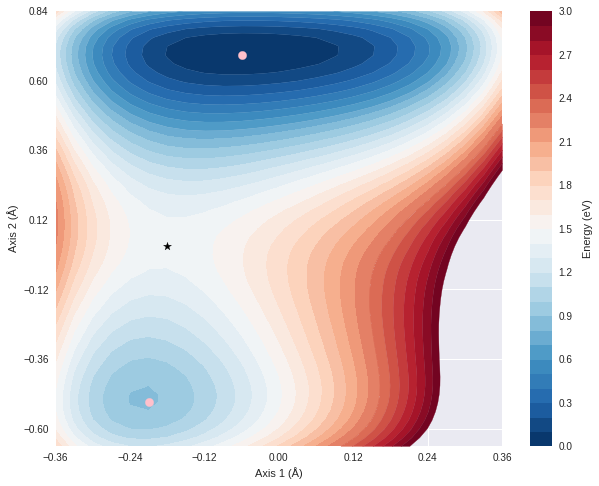

In [23]:
# Create countour plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
levels = np.linspace(0, 3, 31)

fig, ax, cp = plot_potential(y, data.T, y=x, levels=levels, fig=fig, ax=ax)

# Add minima/maxima/saddles to plot
for i, j in minima:
    ax.scatter(y[j], x[i], marker='o', s=70, color='pink')

for i, j in saddles:
    ax.scatter(y[j], x[i], marker='*', s=70, color='black')

# Format plot
ax.set_xlabel("Axis 1 (Å)")
ax.set_ylabel("Axis 2 (Å)")
dr = 0.06

ax.set_xlim([np.amin(y), np.amax(y)])
ax.set_ylim([np.amin(x), np.amax(x)])

stride = 2*dr
plt.xticks(np.arange(np.amin(y), np.amax(y)+stride, stride))
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)

stride = 4*dr
plt.yticks(np.arange(np.amax(x), np.amin(x), -stride)[::-1])

plt.show()